In [1]:
import pandas as pd
import json
from glob import glob
import os.path as osp
import datetime
import wordcloud
from io import StringIO
import stop_words
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import re

In [2]:
pd.set_option('display.max_colwidth', 255)

In [23]:
subjects = []
for media in ['France 2', 'TF1']:
    for year in ['2022']:
        for month in ['1', '2']:
            month_path = f'../data-news-json/media={media}/year={year}/month={month}'
            day_files = glob(f'{month_path}/day=*/*.json')
            for day_file in day_files:
                for line in open(day_file):
                    subject = json.loads(line)
                    subject['media'] = media.lower().replace(' ', '')
                    subjects.append(subject)

In [24]:
data = pd.DataFrame(subjects)

In [25]:
data.head()

,title,description,date,order,presenter,authors,editor,editorDeputy,url,urlTvNews,containsWordGlobalWarming,media
0,Nouvel An 2022 : les Français ont fait la fête malgré le contexte sanitaire,"Rien n’a arrêté les Français vendredi 31 décembre, pour fêter le passage à la nouvelle année, pas même le contexte sanitaire. ""Les gens arrivent à faire la fête mine de rien, et à oublier tout ce qu’il s’est passé"", dit une passante, sur les Champs-El...",2022-01-01T00:00:00.000+01:00,1,Laurent Delahousse,"[J.Debraux, C.Rougerie, A.Rémond, C.Cuello, F.Simoès, A.Etienne, S.Gripon, France 3 Régions, L.Lavieille]",Elsa Pallot,[Thibaud de Barbeyrac],https://www.francetvinfo.fr/sante/maladie/coronavirus/nouvel-an-2022-les-francais-ont-fait-la-fete-malgre-le-contexte-sanitaire_4901089.html,https://www.francetvinfo.fr/replay-jt/france-2/20-heures/jt-de-20h-du-samedi-1-janvier-2022_4881617.html,False,france2
1,"Nouvel An 2022 : une nuit de réveillon magique, de New York à Rio","Partout dans le monde, la tradition du Nouvel An a été respectée, vendredi 31 décembre. Le ciel s'est illuminé à Londres (Royaume-Uni). Le Big Ben, encore en rénovation, a retenti à minuit, après quatre ans de silence. Des milliers de personnes se son...",2022-01-01T00:00:00.000+01:00,2,Laurent Delahousse,"[Récit : E.Cornet, Montage : M.Le Rue]",Elsa Pallot,[Thibaud de Barbeyrac],https://www.francetvinfo.fr/sante/maladie/coronavirus/nouvel-an-2022-une-nuit-de-reveillon-magique-de-new-york-a-rio_4901107.html,https://www.francetvinfo.fr/replay-jt/france-2/20-heures/jt-de-20h-du-samedi-1-janvier-2022_4881617.html,False,france2
2,"Covid-19 : dès le 3 janvier, le port du masque sera obligatoire dès 6 ans dans certains lieux publics","Dès lundi 3 janvier, le port du masque ne sera plus seulement imposé en classe, pour les enfants de plus de six ans, mais aussi dans certains lieux publics. ""Je suis habituée, souffle une petite fille. Je le porte dans la rue, en ville"". La mesure s’a...",2022-01-01T00:00:00.000+01:00,3,Laurent Delahousse,"[C.Rougerie, E.Cornet, J.Coulais, M.Birden, D.Breysse, C.Pary, France 3 Régions, N.Sadok]",Elsa Pallot,[Thibaud de Barbeyrac],https://www.francetvinfo.fr/sante/maladie/coronavirus/masques-sanitaires/covid-19-des-le-3-janvier-le-port-du-masque-sera-obligatoire-des-6-ans-dans-certains-lieux-publics_4901091.html,https://www.francetvinfo.fr/replay-jt/france-2/20-heures/jt-de-20h-du-samedi-1-janvier-2022_4881617.html,False,france2
3,Urgences : certaines visites sont désormais payantes,"Il faudra désormais s’habituer à sortir la carte bleue après un passage aux urgences. En effet, chaque visite dans les services d’urgences n’entraînant pas d’hospitalisation sera désormais payante. Un reste à charge de 19,61 euros. Une manière pour le...",2022-01-01T00:00:00.000+01:00,4,Laurent Delahousse,"[A.Jolly, G.Marque, G.Liaboeuf]",Elsa Pallot,[Thibaud de Barbeyrac],https://www.francetvinfo.fr/sante/hopital/urgences-certaines-visites-sont-desormais-payantes_4901127.html,https://www.francetvinfo.fr/replay-jt/france-2/20-heures/jt-de-20h-du-samedi-1-janvier-2022_4881617.html,False,france2
4,Sarthe : inquiétude et émotion lors des adieux d'un médecin de campagne,"Une page se tourne à Guécélard, une petite commune de la Sarthe de 3 000 habitants. Geneviève Poiré, la dernière médecin de la ville, prend sa retraite après 33 ans passés à y soigner. ""On ne réalise pas tout à fait, quand on retire la plaque. Comme a...",2022-01-01T00:00:00.000+01:00,5,Laurent Delahousse,"[A-C.Roth, M.Birden, N.El Abid, E.Urtado]",Elsa Pallot,[Thibaud de Barbeyrac],https://www.francetvinfo.fr/sante/soigner/sarthe-inquietude-et-emotion-lors-des-adieux-d-un-medecin-de-campagne_4901097.html,https://www.francetvinfo.fr/replay-jt/france-2/20-heures/jt-de-20h-du-samedi-1-janvier-2022_4881617.html,False,france2


In [26]:
data[['sientifiques' in c.lower()  for c in data.description]]

,title,description,date,order,presenter,authors,editor,editorDeputy,url,urlTvNews,containsWordGlobalWarming,media


In [27]:
data[['méthane' in c.lower() for c in data.description]]

,title,description,date,order,presenter,authors,editor,editorDeputy,url,urlTvNews,containsWordGlobalWarming,media


In [28]:
data[['catastrophe' in c.lower() and 'météo' in c.lower()  for c in data.description]]

,title,description,date,order,presenter,authors,editor,editorDeputy,url,urlTvNews,containsWordGlobalWarming,media


In [29]:
last_week = data[data["date"] >= (datetime.datetime.now() -datetime.timedelta(days=7)).strftime('%Y-%m-%d')]

In [30]:
text = "\n".join([str(x) for x in last_week['title']])

In [31]:
text[:100]

"Électricité : une flambée des tarifs contenue par l’État\nHausse des prix : combien de temps l'inflat"

In [32]:
stop_words_fr=stop_words.get_stop_words('fr') + ['enquête', 'plus', 'france', 'français', 'va']

In [33]:
cv = CountVectorizer(stop_words=stop_words_fr, min_df=3, max_df=.2)

In [34]:
X = cv.fit_transform(last_week['title'])

In [35]:
X.shape

(106, 32)

In [36]:
wid2word = {wid:word for word,wid in cv.vocabulary_.items()}

In [37]:
frequencies = {wid2word[w]:f for w,f in enumerate(X.sum(axis=0).tolist()[0])}

In [38]:
colors = sns.color_palette('Blues_r', len(frequencies))
word_color = {w[0]:colors[k] for k,w in enumerate(sorted(frequencies.items(), key=lambda x: -x[1]))}
def freq_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple([int(x * 255) for x in word_color[word]] + [1])

In [39]:
wc = wordcloud.WordCloud(background_color='white', width=400, height=400, prefer_horizontal=1, color_func=freq_color_func, relative_scaling=True)

In [40]:
wc.generate_from_frequencies(frequencies)

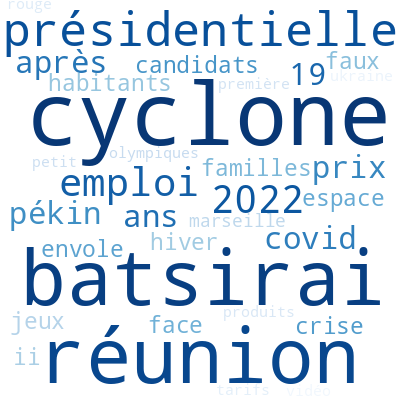

In [41]:
wc.to_image()

In [42]:
    last_week[['argent' in c.lower() for c in last_week.title]][['media', 'date', 'title', 'description']]

,media,date,title,description
444,france2,2022-02-05T00:00:00.000Z,JO 2022 : les biathlètes du relais mixte décrochent la première médaille des Bleus et remportent l’argent,"La France enregistre sa première médaille aux Jeux olympiques de Pékin 2022. Les biathlètes du relais mixte ont remporté l’argent, après une journée difficile, notamment à cause des conditions climatiques. Il faisait -19°C, samedi 5 février, avec un v..."
710,tf1,2022-02-01T00:00:00.000Z,Hausse du prix des péages : où va l'argent qu'ils récoltent ?,"L'essentiel Les tarifs des péages autoroutiers augmentent de 2% en moyenne ce mardi 1er février. Combien rapportent-ils chaque année et à quoi sert cet argent ? Le 20H de TF1 vous explique. Pour que les barrières de péages se lèvent, vous dépensez en..."
